# Sample Montecarlo Slice-And-Dice Analysis for Image Classification

In [1]:
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import base64
from PIL import Image

This file contains the inputs and outputs of an endpoint, as per MC format

In [2]:
with open( 'capture_small.json') as f:
    captures = json.loads(f.read())

This is the number of inferences we have captured

In [3]:
sample_no = len(captures)
print( f'We have captured the trace for {sample_no} inferences, each containing one image')

We have captured the trace for 99 inferences, each containing one image


We can now run our analysis. Note that this is the same basic code that describes `input_fn`:
- read the data
- assume that the payload is simply an image, with no parameters
- decode the image
- measure the X\*Y
- resize to the canonical size required by the model 
- measure the luminance (average pixel value across the R,G,B channels, normalized to 0..1)

In [9]:
inference_size = (224, 224) 
pixs = []
pixelno = []
luminances = []
model_inputs = []
for cap in captures:
    # The raw payload, expressed as base64
    raw_base64 = cap['capturedData']['0']['data']
    # These bytes describe a jpeg image
    raw_decoded = base64.b64decode(raw_base64)
    try:
        raw_asbytes = io.BytesIO(raw_decoded)
        # Decoded image
        byteImg = Image.open(raw_asbytes)
        pix = np.array(byteImg)
        if len(pix.shape) != 3:
            continue
        # size of the image
        x,y,c = pix.shape
        # list of image sizes 
        pixelno.append(x*y)
        # now we resize to 224x224
        byteImg = Image.Image.resize(byteImg, size=inference_size)
        pix = np.array(byteImg)
        pixs.append(pix)
        # we also normalize to 0..1
        pix = pix / 255
        # and subtract the mean
        pix = pix - (0.485, 0.456, 0.406)
        model_inputs.append(pix)
    except:
        continue
    # luminance is the average pixel value, normalized to 0..1
    luminance = np.sum(pix)/np.product(pix.shape)/255    
    luminances.append(luminance)
luminances = np.array(luminances)

We can show the distribution of image sizes. This information can be obtained by examining the payload

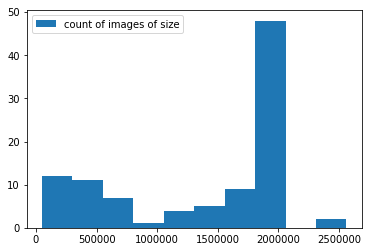

In [28]:
plt.hist(pixelno, label='count of images of size')
plt.legend()
plt.show()

We can also show the distribution of luminances ([0..1]). This can only be done by looking at the image after it has been resized and normalized

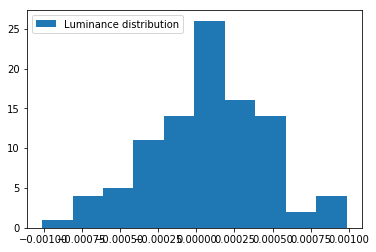

In [29]:
plt.hist(luminances, label='Luminance distribution')
plt.legend()
plt.show()

Images after they have been decoded and resized

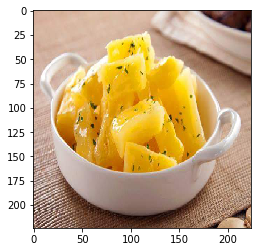

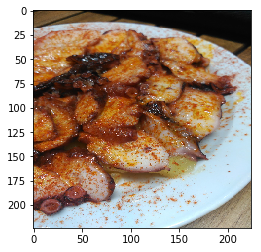

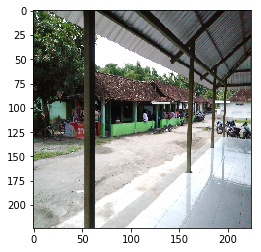

In [31]:
for i in range(3):
    ndx = np.random.randint(len(pixs))
    plt.imshow(pixs[ndx])
    #plt.imshow(model_inputs[ndx])
    plt.show()